In [7]:
from IPython.display import Image
from community_simulator import *
from community_simulator.usertools import *
from community_simulator.visualization import *
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Introduction

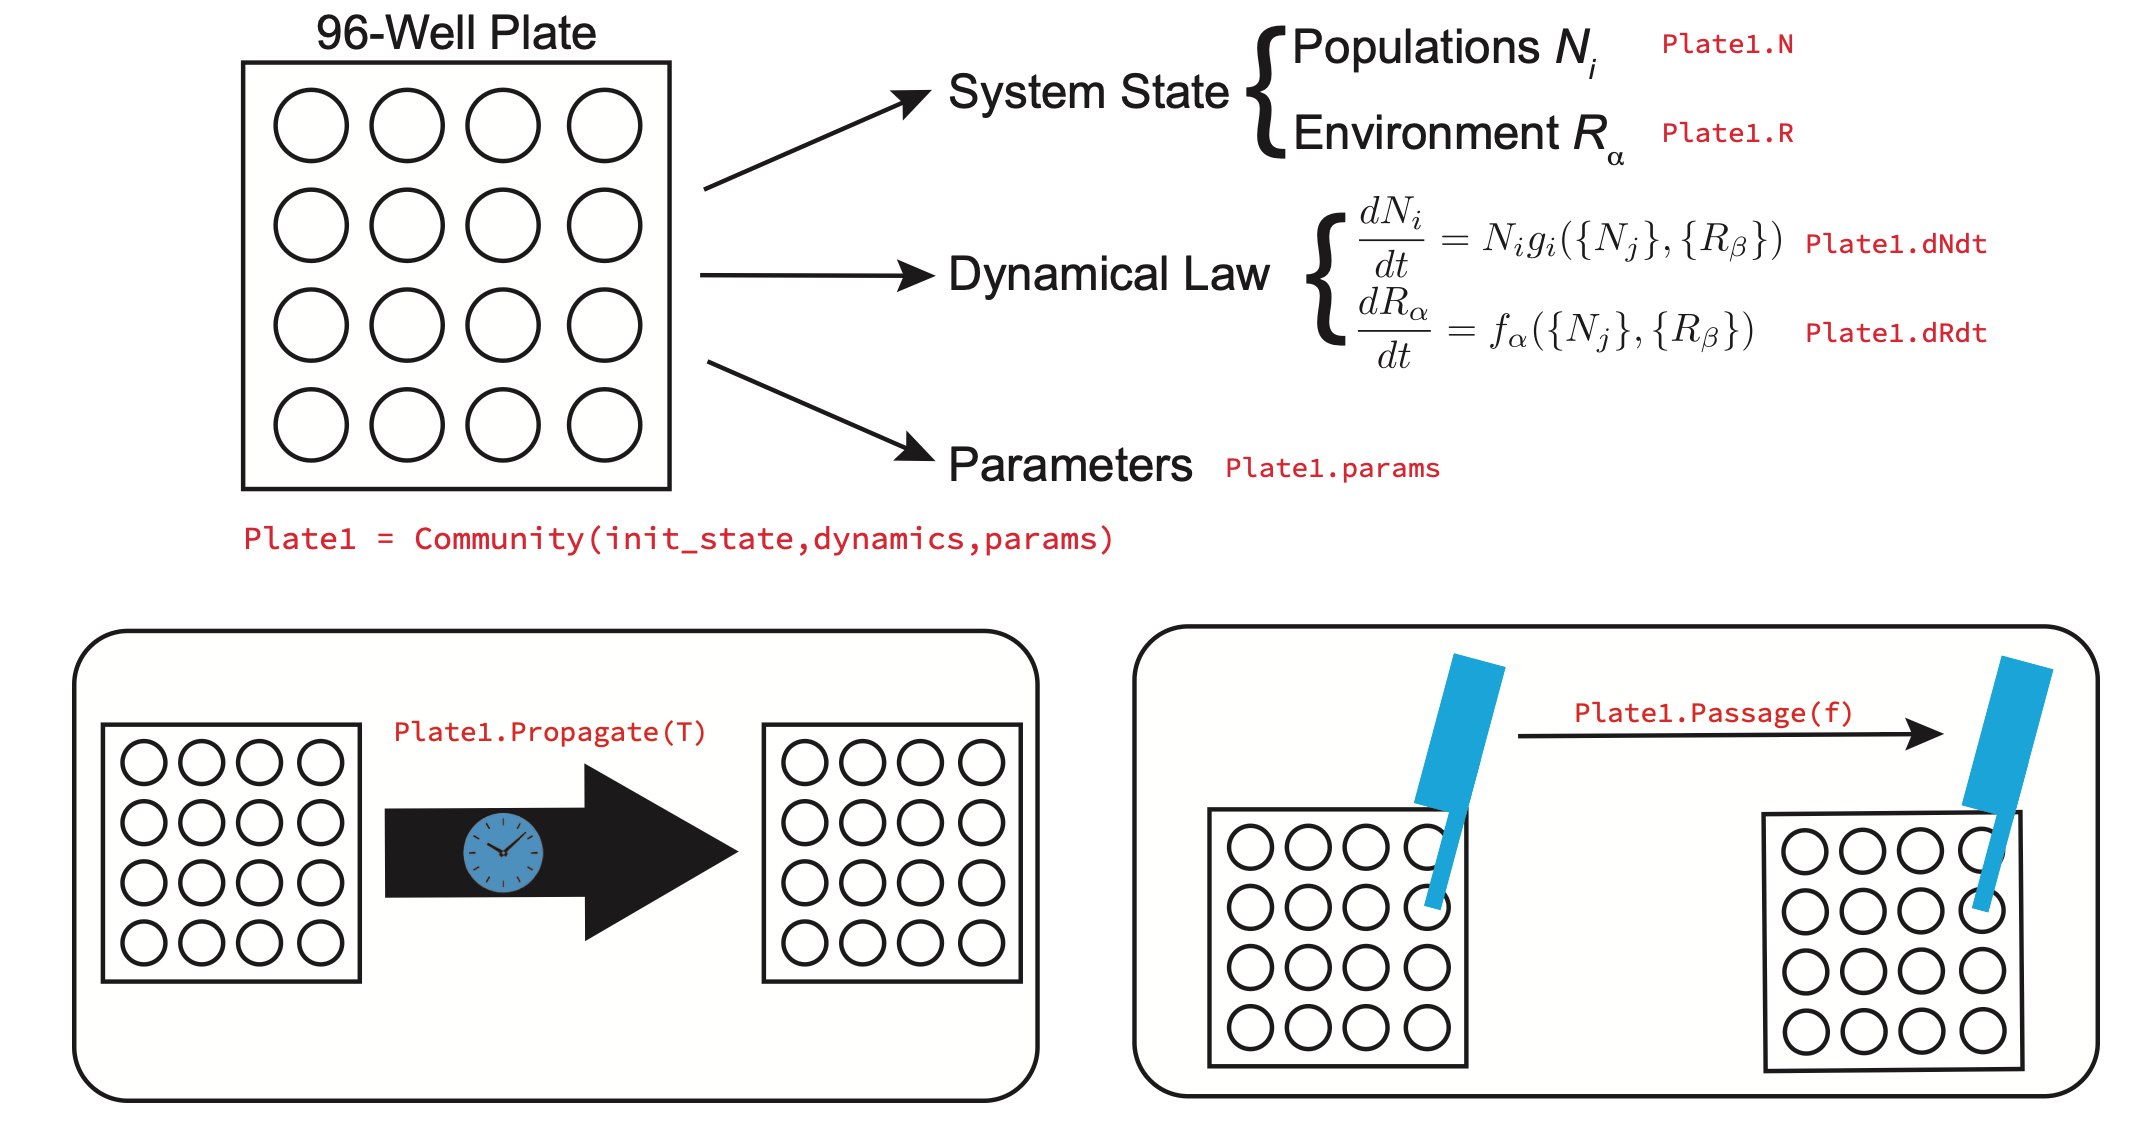

In [7]:
Image("schematic.png")

As illustrated in the figure above, Community Simulator is designed to run dynamics on multiple communities in parallel, inspired by the parallel experiments commonly performed with 96-well plates. The central object of the package is a `Community` class, whose instances are initialized by specifying the initial population sizes and resource concentrations for each parallel "well," along with the functions and parameters that define the population dynamics. This class contains two core methods:
- `Propagate(T)` sends each community to a separate CPU (for however many CPU's are available), runs the given population dynamics for a time $T$ using the SciPy function `odeint`, and updates the population sizes and resource concentrations in each well to the time-evolved values.
- `Passage(f)` initializes a fresh set of wells by adding a fraction $f_{\mu\nu}$ of the contents of each old well $\nu$ to each new well $\mu$. (Fresh media can also be added at this point, but this feature was not relevant for the current work). The resulting values of $N_i$ are converted from arbitrary concentration units to actual population sizes using a specified scale factor, and then integer population sizes are obtained by multinomial sampling based on these values. 

The package also contains a set of scripts for generating models and randomly sampling parameters. `MakeConsumerDynamics` and `MakeResourceDynamics` from the `usertools` module take a dictionary of assumptions concerning the response type, metabolic regulation and resource replenishment, and generate the corresponding dynamics using the Microbial Consumer Resource Model described in https://arxiv.org/abs/1805.12516. The function `MakeMatrices`, from the same module, samples the consumer matrix $c_{i\alpha}$ and the metabolic matrix $D_{\alpha\beta}$ according to the scheme described in the paper.

# Dynamics

## Functional Response

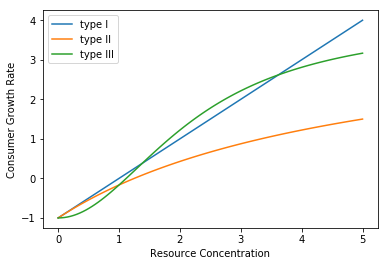

In [2]:
mp = {'regulation':'independent'}

Rvec = np.linspace(0,5,100)
params_plot = {'c':np.eye(100),
              'm':1,
              'g':1,
              'w':1,
              'D':np.eye(100),
              'l':0,
              'sigma_max':5,
              'n':2}

fig,ax = plt.subplots()

for response in ['type I','type II','type III']:
    mp['response'] = response
    
    #Make dynamics
    def dNdt(N,R,params):
        return MakeConsumerDynamics(mp)(N,R,params)

    ax.plot(Rvec,dNdt(np.ones(100),Rvec,params_plot),label=response)
    
plt.legend()
ax.set_xlabel('Resource Concentration')
ax.set_ylabel('Consumer Growth Rate')
plt.show()

## Regulation

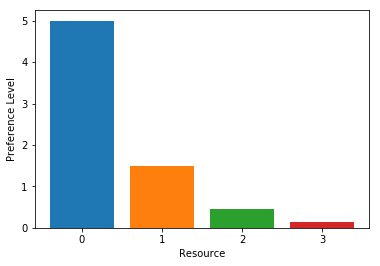

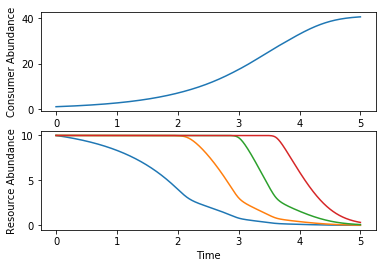

In [3]:
mp_diaux = {
              'regulation':'energy',
              'supply':'off',
              'response':'type II'
             }

#Construct dynamics
def dNdt(N,R,params):
    return MakeConsumerDynamics(mp_diaux)(N,R,params)
def dRdt(N,R,params):
    return MakeResourceDynamics(mp_diaux)(N,R,params)
dynamics_diaux = [dNdt,dRdt]

#Construct matrices 
M = 4
c = np.exp(np.linspace(np.log(5),-2,M))
c = c[np.newaxis,:]

fig,ax=plt.subplots()
for k in range(M):
    ax.bar(k,c.squeeze()[k])
ax.set_xticks(np.arange(4,dtype=int))
ax.set_xlabel('Resource')
ax.set_ylabel('Preference Level')
plt.show()

#Make initial state
N0 = np.asarray([1])
R0 = np.ones(M)*10
init_state = [N0,R0]

#Make parameter list
params = {'c':c,
        'm':0,
        'w':1,
        'g':1,
        'l':0,
        'R0':R0,
        'tau':1,
        'sigma_max':1,
        'nreg':10
       }

diauxic = Community(init_state,dynamics_diaux,params)

fig,axs=plt.subplots(2)
out = diauxic.TestWell(T=5,ns=1000,axs=axs)
plt.show()

# Parameter Sampling

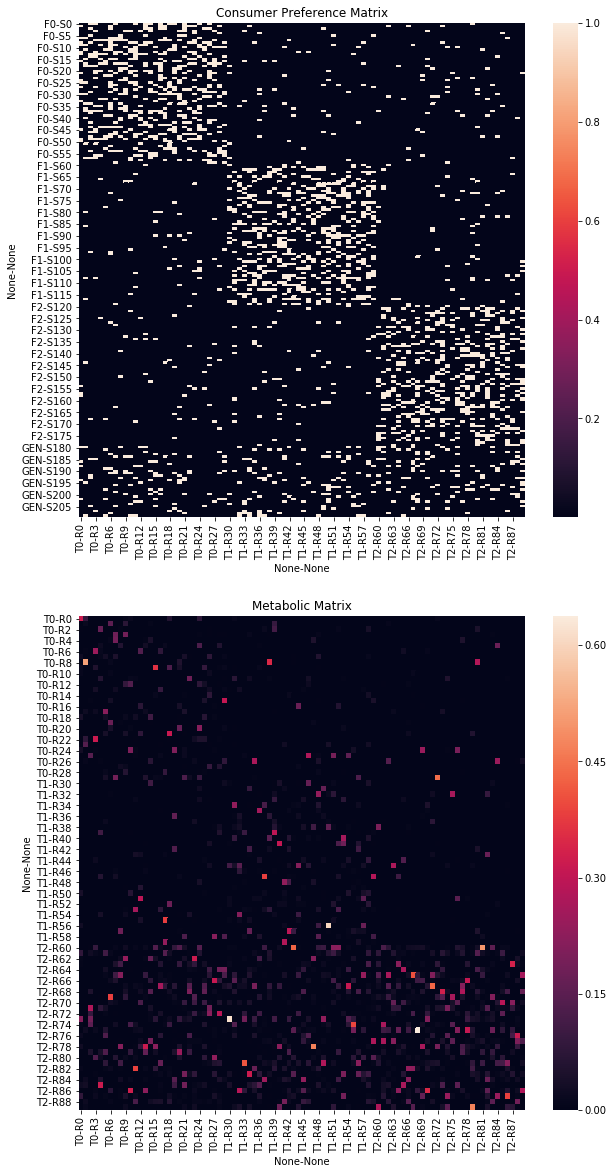

In [8]:
#Make matrices
c,D = MakeMatrices(a_default)

#Plot matrices
fig,axs = plt.subplots(2,figsize=(10,20))
sns.heatmap(c,ax=axs[0])
axs[0].set_title('Consumer Preference Matrix')
sns.heatmap(D,ax=axs[1])
axs[1].set_title('Metabolic Matrix')
plt.show()

# Stochastic Colonization

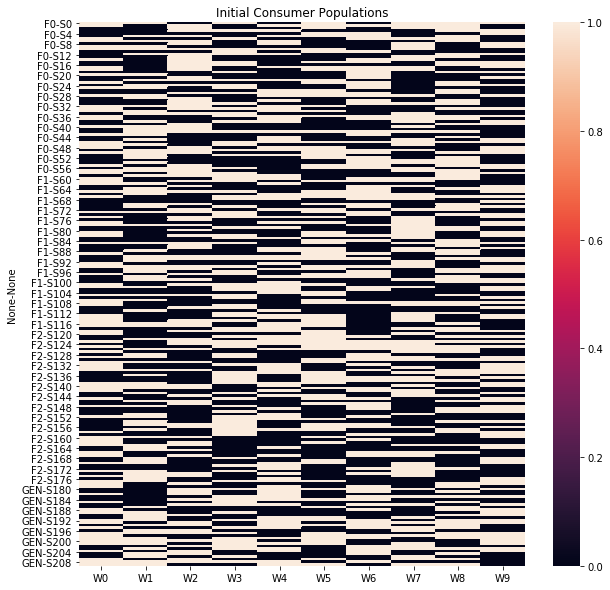

In [9]:
#Make initial state
N0,R0 = MakeInitialState(a_default)

fig,ax = plt.subplots(figsize=(10,10))
sns.heatmap(N0,ax=ax)
ax.set_title('Initial Consumer Populations')
plt.show()

# Example: Combining Two Carbon Sources

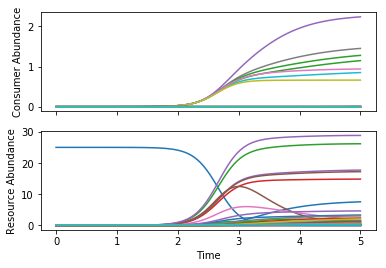

In [10]:
#Set up dynamics, initial state and matrices
mp = a_default.copy()
def dNdt(N,R,params):
    return MakeConsumerDynamics(mp)(N,R,params)
def dRdt(N,R,params):
    return MakeResourceDynamics(mp)(N,R,params)
c,D = MakeMatrices(mp)
N0,R0 = MakeInitialState(mp)
N0 = N0*1e-6

#Make parameter dictionary. Assign lower energy density and lower leakage fraction
#to third resource type, which will represent carboxylic acids
params = {'c':c,
         'D':D,
         'w':np.hstack((np.ones(30),np.ones(30),np.ones(30)*0.1)),
         'g':1,
         'm':0,
         'l':np.hstack((np.ones(30)*0.8,np.ones(30)*0.8,np.ones(30)*0.5)),
         'tau':1}

#Set up initial resource concentrations: only glucose or only citrate
#(with higher citrate concentration so total energy content remains fixed)
R0_g = np.zeros((len(D),mp['n_wells']))
R0_c = np.zeros((len(D),mp['n_wells']))
R0_g[0,:] = 25
R0_c[60,:] = 250

#Initialize plates -- single carbon sources and 50/50 mix
#NOTE: parallel = False will make experiments run slower, but guarantees
#compatibility with Windows (see Readme)
glucose = Community([N0,R0_g],[dNdt,dRdt],params,parallel=False)
citrate = Community([N0,R0_c],[dNdt,dRdt],params,parallel=False)
mix = Community([N0,0.5*(R0_g+R0_c)],[dNdt,dRdt],params,parallel=False)

#Test a single dilution cycle
glucose.TestWell(T=5)
plt.show()

In [12]:
#Run serial dilution experiments with dilution factor of 0.2
Ntraj, Rtraj = glucose.RunExperiment(np.eye(mp['n_wells'])/5,5,20)
Ntraj, Rtraj = citrate.RunExperiment(np.eye(mp['n_wells'])/5,5,20)
Ntraj, Rtraj = mix.RunExperiment(np.eye(mp['n_wells'])/5,5,20)

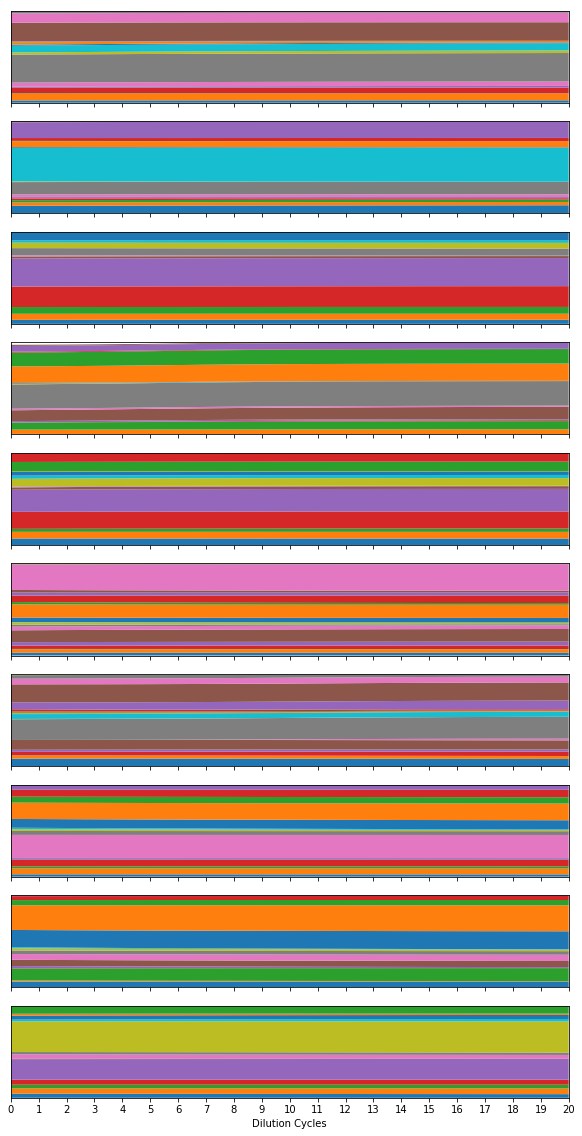

In [13]:
#Plot timeseries of two-carbon communities, sampling after each dilution:
PlotTraj(Ntraj)
plt.show()

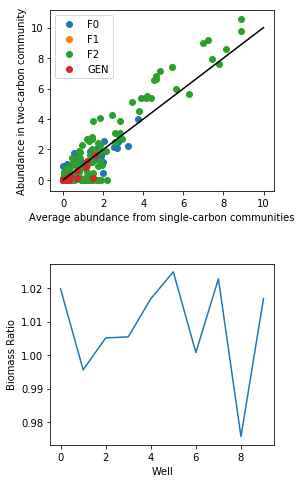

In [14]:
fig,axs = plt.subplots(2,figsize=(4,8))
fig.subplots_adjust(hspace = 0.4)

#Make scatter plot of abundances in two-carbon community vs. average
#of abundances in single-carbon communities, colored by family
for family in N0.index.levels[0]:
    axs[0].scatter(0.5*(glucose.N.loc[family].values.reshape(-1)+
                        citrate.N.loc[family].values.reshape(-1)),
                   mix.N.loc[family].values.reshape(-1),label = family)
    
#Add line with slope 1 for reference
axs[0].plot([0,10],[0,10],'k')
axs[0].legend()

#Plot ratio of total biomass in two-carbon community to average of biomasses
#of single-carbon communities
axs[1].plot(mix.N.sum().values/(0.5*(glucose.N.sum()+citrate.N.sum()).values))
axs[0].set_xlabel('Average abundance from single-carbon communities')
axs[0].set_ylabel('Abundance in two-carbon community')
axs[1].set_xlabel('Well')
axs[1].set_ylabel('Biomass Ratio')

plt.show()